In [95]:
#!pip install hdbscan umap-learn

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import hdbscan
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# HDBSCAN

In [34]:
def get_color_map_for_labels(datasets):
    all_labels = pd.concat([df.iloc[:, 0] for df in datasets.values()])
    unique_labels = all_labels.unique()
    num_labels = len(unique_labels)
    cmap = cm.rainbow(np.linspace(0, 1, num_labels))
    color_map = dict(zip(unique_labels, cmap))
    return color_map

In [43]:
def hdbscan_clustering(datasets):
    color_map = get_color_map_for_labels(datasets)

    results = []
    fig, axes = plt.subplots(len(datasets), 3, figsize=(18, 4 * len(datasets)))

    for i, (name, df) in enumerate(datasets.items()):
        labels_true = df.iloc[:, 0]
        numeric_data = df.iloc[:, 1:]

        # HDBSCAN
        model = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='manhattan')
        labels_pred = model.fit_predict(numeric_data)
        df['cluster'] = labels_pred

        # PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(numeric_data)

        n_clusters = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
        n_noise = list(labels_pred).count(-1)
        silhouette = (
            silhouette_score(numeric_data, labels_pred)
            if n_clusters > 1 else None
        )

        results.append({
            "n_gram": name,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette_score": silhouette
        })

        ax = axes[i, 0] if len(datasets) > 1 else axes[0]
        ax.scatter(
            pca_result[:, 0], pca_result[:, 1],
            c=labels_true.map(color_map),
            s=40, edgecolor='k'
        )
        ax.set_title(f"HDBSCAN Clusters ({name}) – boje po labelama")
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")

        # Condensed tree
        plt.sca(axes[i, 1] if len(datasets) > 1 else axes[1])
        model.condensed_tree_.plot(select_clusters=True)
        axes[i, 1].set_title(f"Condensed Tree ({name})")

        # Single linkage tree
        plt.sca(axes[i, 2] if len(datasets) > 1 else axes[2])
        model.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
        axes[i, 2].set_title(f"HDBSCAN Single Linkage Tree ({name})")

    plt.tight_layout()
    plt.show()

    results_df = pd.DataFrame(results)
    print(results_df)


In [39]:
df6 = pd.read_csv("../csv_data/6gram_matrix_nucleotide_combined.csv")
df7 = pd.read_csv("../csv_data/7gram_matrix_nucleotide_combined.csv")
df8 = pd.read_csv("../csv_data/8gram_matrix_nucleotide_combined.csv")
df9 = pd.read_csv("../csv_data/9gram_matrix_nucleotide_combined.csv")

datasets = {
    "6-gram": df6,
    "7-gram": df7,
    "8-gram": df8,
    "9-gram": df9
}

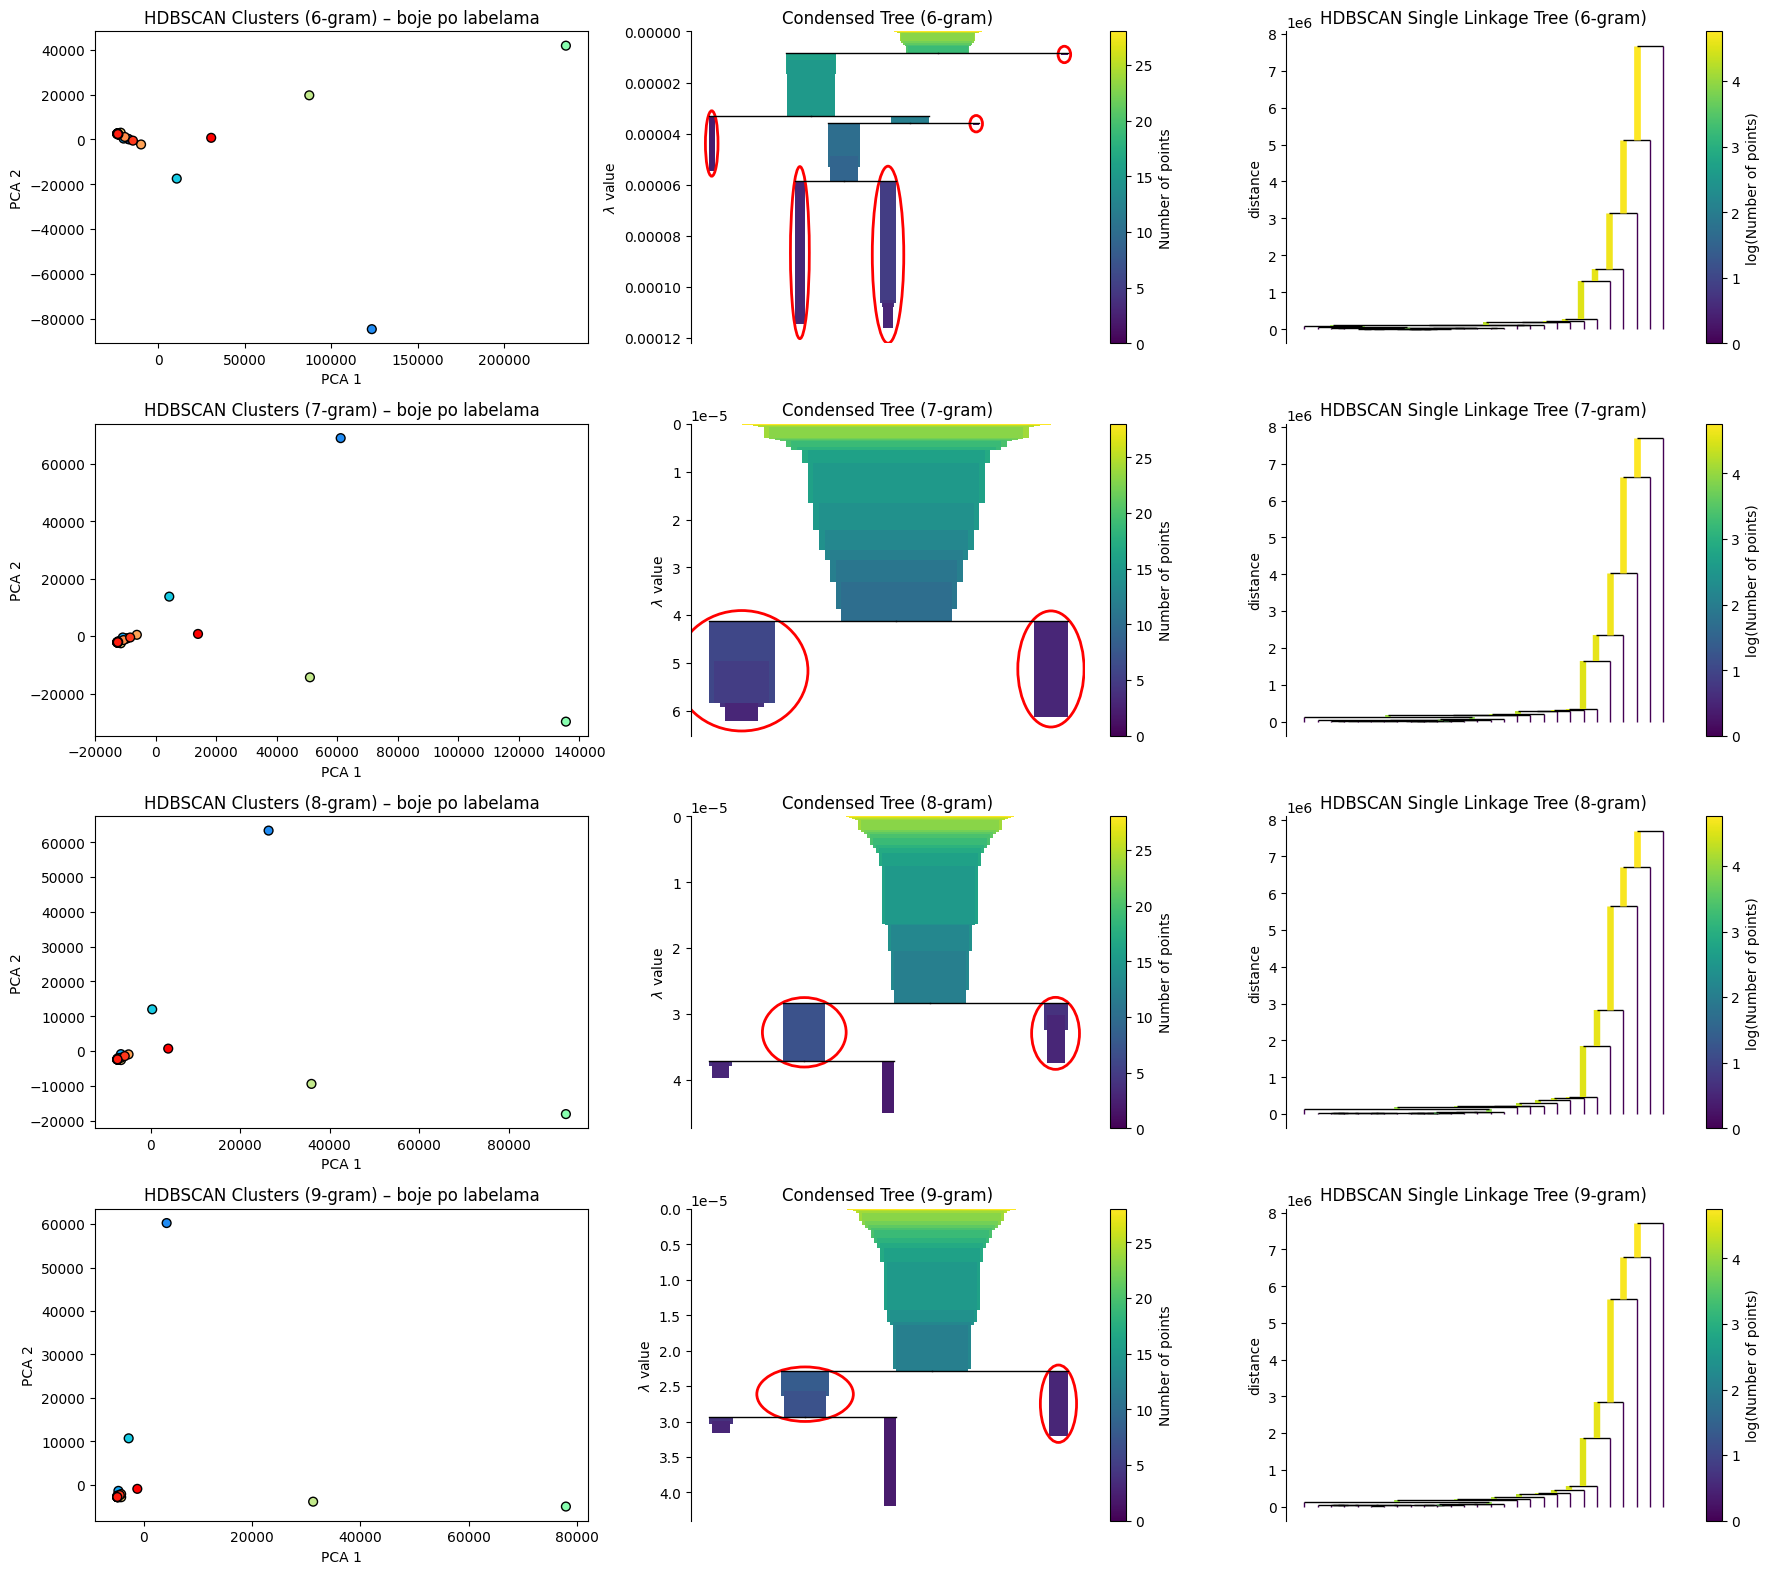

   n_gram  n_clusters  n_noise  silhouette_score
0  6-gram           5       14         -0.099498
1  7-gram           2       19         -0.380292
2  8-gram           2       17         -0.335580
3  9-gram           2       17         -0.351937


In [42]:
hdbscan_clustering(datasets)

#  Hierarchical Clustering

In [24]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [9]:
def hierarchical_clustering(datasets):
    cluster_range = range(2, 11)
    results = {ngram: {"clusters": [], "silhouette": [], "calinski": [], "davies": []} for ngram in datasets}
    
    # Grid search
    for ngram, data in datasets.items():
        
        data_numeric = data.drop(data.columns[0], axis = 1)
        
        for k in cluster_range:
            model = AgglomerativeClustering(n_clusters=k)
            labels = model.fit_predict(data_numeric)
            results[ngram]["clusters"].append(k)
            results[ngram]["silhouette"].append(silhouette_score(data_numeric, labels))
            results[ngram]["calinski"].append(calinski_harabasz_score(data_numeric, labels))
            results[ngram]["davies"].append(davies_bouldin_score(data_numeric, labels))
    
    # Plot metric scores for each n-gram
    fig, axes = plt.subplots(4, 3, figsize=(18, 12))
    metrics = ["silhouette", "calinski", "davies"]
    
    for i, (ngram, scores) in enumerate(results.items()):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            ax.plot(scores["clusters"], scores[metric], marker='o')
            ax.set_title(f"{ngram} - {metric}")
            ax.set_xlabel("Number of Clusters")
            ax.set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

In [5]:
df6 = pd.read_csv("../csv_data/6gram_matrix_nucleotide_combined.csv")
df7 = pd.read_csv("../csv_data/7gram_matrix_nucleotide_combined.csv")
df8 = pd.read_csv("../csv_data/8gram_matrix_nucleotide_combined.csv")
df9 = pd.read_csv("../csv_data/9gram_matrix_nucleotide_combined.csv")

datasets = {
    "6-gram": df6,
    "7-gram": df7,
    "8-gram": df8,
    "9-gram": df9
}

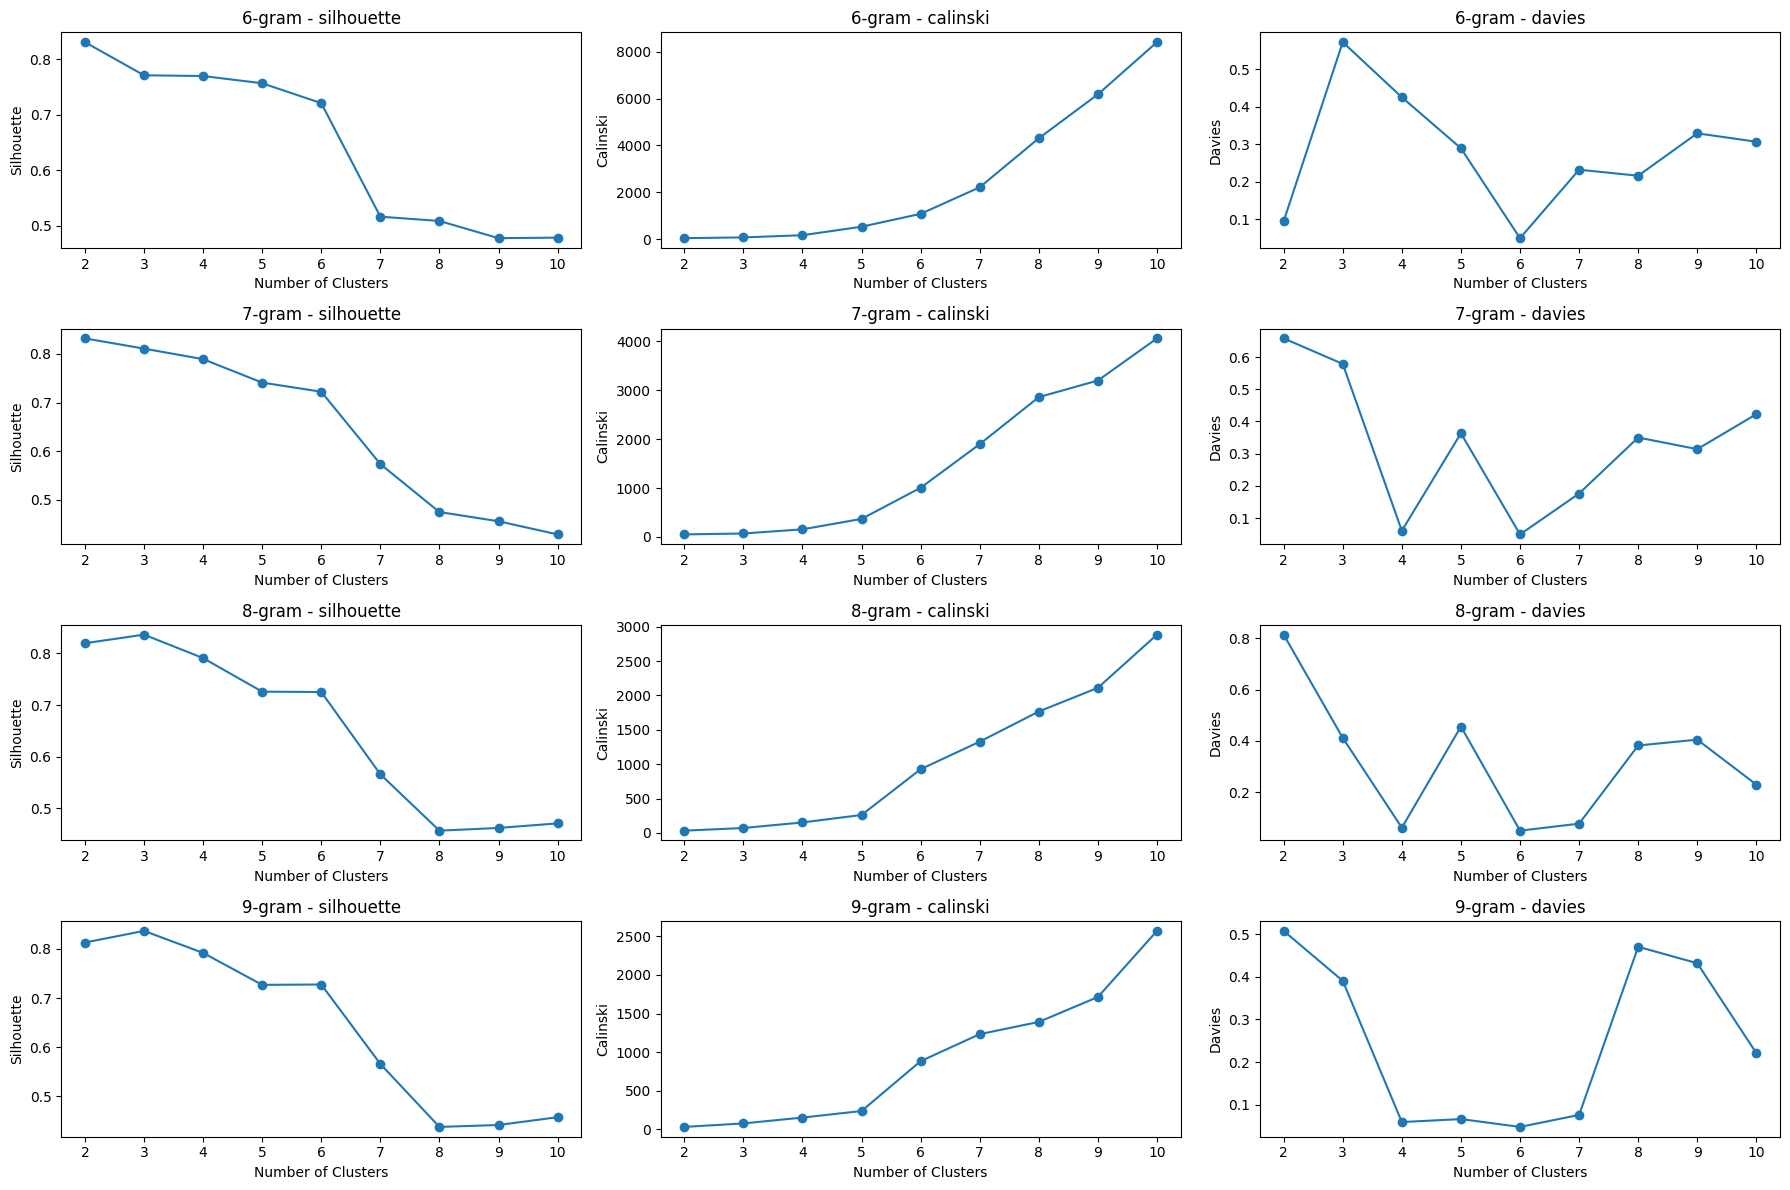

In [10]:
hierarchical_clustering(datasets)

In [25]:
def get_color_map_for_labels(datasets):
    all_labels = pd.concat([df.iloc[:, 0] for df in datasets.values()])
    unique_labels = all_labels.unique()
    num_labels = len(unique_labels)
    cmap = cm.rainbow(np.linspace(0, 1, num_labels))
    color_map = dict(zip(unique_labels, cmap))
    return color_map

In [32]:
def visualize_clusters_only(datasets, k=2):
    color_map = get_color_map_for_labels(datasets) 

    n_plots = len(datasets)
    fig, axs = plt.subplots(1, n_plots, figsize=(18, 5))
    if n_plots == 1:
        axs = [axs]

    for ax, (label, df) in zip(axs, datasets.items()):
        labels = df.iloc[:, 0]  
        numeric_data = df.iloc[:, 1:]  

        pca = PCA(n_components=2, random_state=42)
        reduced_data = pca.fit_transform(numeric_data.values)

        model = AgglomerativeClustering(n_clusters=k)
        clusters = model.fit_predict(numeric_data.values)

        centers = []
        for cluster_id in range(k):
            points_in_cluster = reduced_data[clusters == cluster_id]
            center = points_in_cluster.mean(axis=0)
            centers.append(center)
        centers_2d = np.array(centers)

        colors = labels.map(color_map)

        ax.scatter(
            reduced_data[:, 0], reduced_data[:, 1],
            c=colors,
            s=80, edgecolor='k'
        )

        ax.scatter(
            centers_2d[:, 0], centers_2d[:, 1],
            marker='x', c='black', s=150, linewidths=3, label='Cluster centroid'
        )

        ax.set_title(f"{label} – klasteri i prva kolona", fontsize=14)
        ax.set_xlabel("PCA 1", fontsize=12)
        ax.set_ylabel("PCA 2", fontsize=12)
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

In [27]:
def draw_legend_for_labels(datasets):
    color_map = get_color_map_for_labels(datasets) 
    unique_labels = list(color_map.keys())
    colors = list(color_map.values())

    ncol = 4
    n_rows = int(np.ceil(len(unique_labels) / ncol))
    fig_height = 0.6 + n_rows * 0.3

    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis('off')

    handles = [
        mpatches.Patch(color=colors[i], label=unique_labels[i])
        for i in range(len(unique_labels))
    ]
    ax.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.0),
        fontsize=10,
        ncol=ncol,
        frameon=False
    )

    plt.subplots_adjust(top=1, bottom=0, left=0.05, right=0.95)
    plt.show()


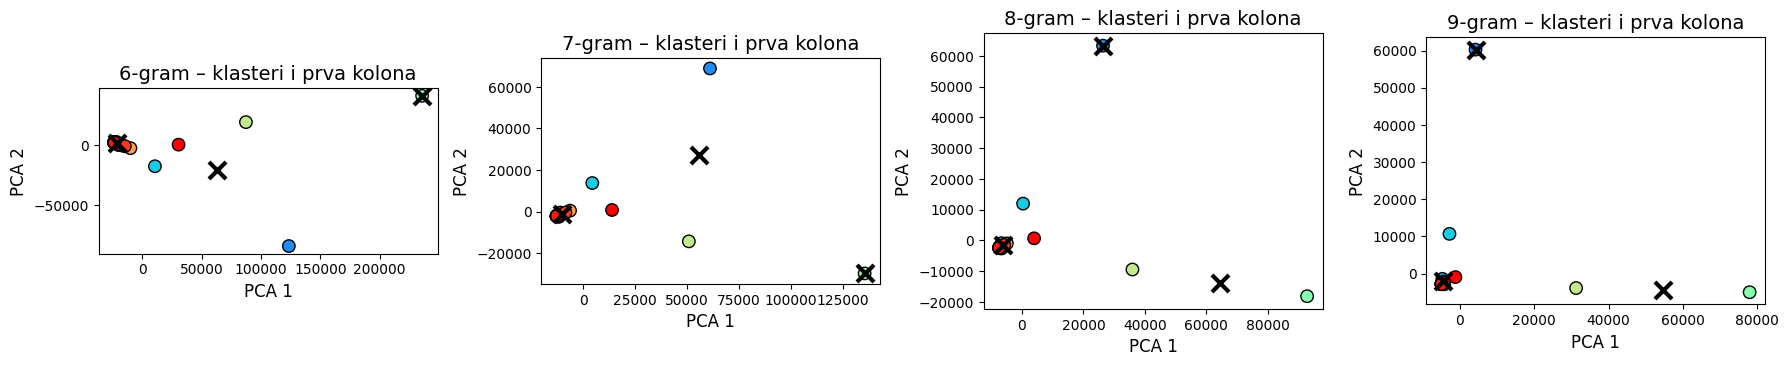

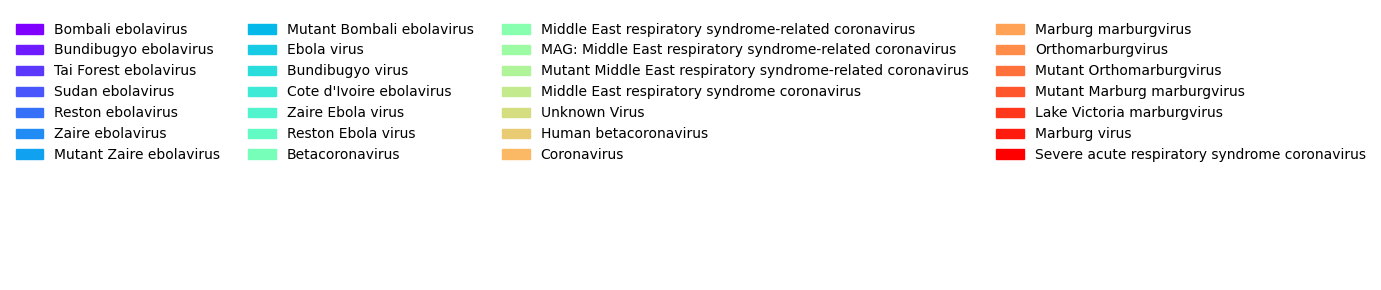

In [33]:
visualize_clusters_only(datasets, k=3)
draw_legend_for_labels(datasets)

In [31]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

def plot_dendrograms_simplified(datasets):
    n_plots = len(datasets)
    fig, axs = plt.subplots(n_plots, 1, figsize=(20, 5 * n_plots))
    if n_plots == 1:
        axs = [axs]

    for ax, (label, df) in zip(axs, datasets.items()):
        data_numeric = df.iloc[:, 2:].values

        Z = linkage(data_numeric, method='ward')

        dendrogram(
            Z,
            ax=ax,
            truncate_mode='level', 
            p=6,                     
            labels=None,            
            leaf_rotation=90,
            leaf_font_size=6,
            show_contracted=True,
            show_leaf_counts=True,     
            distance_sort='descending' 
        )

        ax.set_title(f"Simplified Dendrogram - {label}", fontsize=14)
        ax.set_ylabel("Distance")

    plt.tight_layout()
    plt.show()

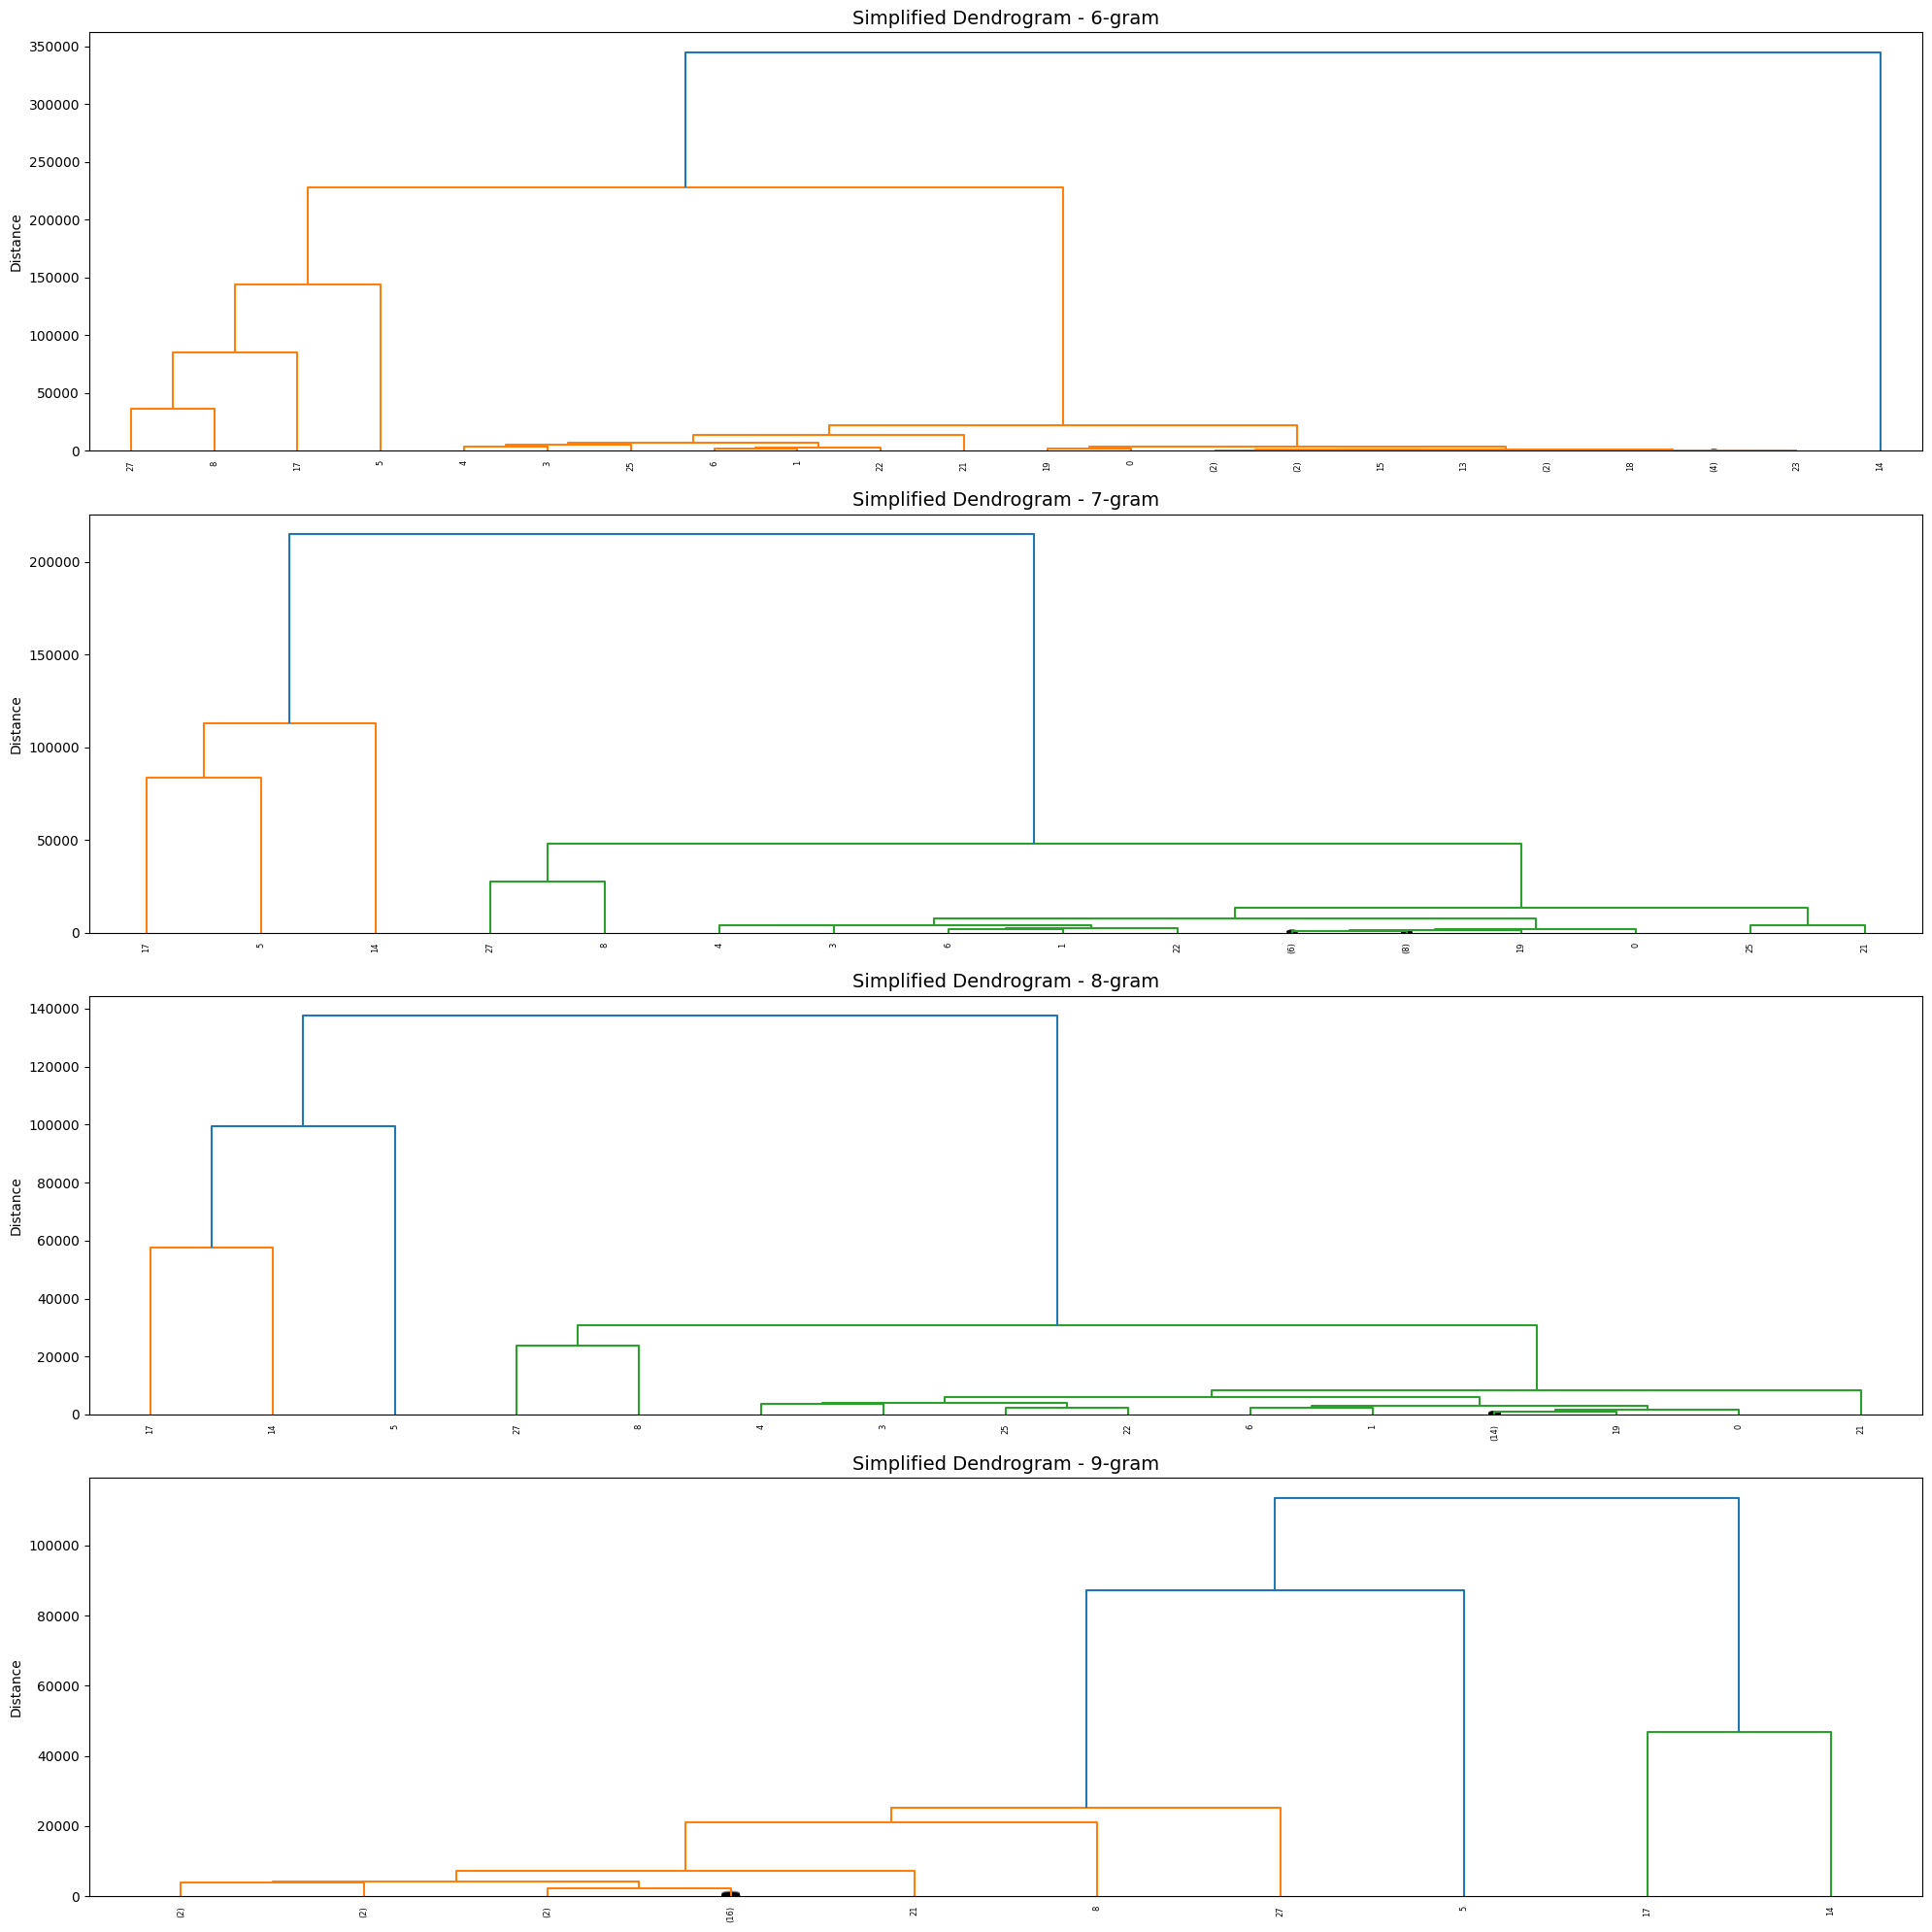

In [30]:
plot_dendrograms_simplified(datasets)

# SOM

In [1]:
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def som(datasets, som_x=15, som_y=15, iterations=1000):
    """
    Trains and visualizes SOMs on nucleotide n-gram datasets.
    Colors are based on the first column (virus type).
    """
    results = []
    fig, axes = plt.subplots(len(datasets), 2, figsize=(12, 5 * len(datasets)))

    if len(datasets) == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, (ngram, df) in enumerate(datasets.items()):
        # Automatically use the first column as label
        label_column = df.columns[0]
        labels = df[label_column].values
        features = df.drop(columns=[label_column]).values

        # Standardize feature data
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Train SOM
        som = MiniSom(x=som_x, y=som_y, input_len=features_scaled.shape[1], sigma=1.0, learning_rate=0.5)
        som.random_weights_init(features_scaled)
        som.train_random(features_scaled, num_iteration=iterations)

        # Get BMU coordinates
        bmu_coords = np.array([som.winner(x) for x in features_scaled])

        # Map labels to color indices
        unique_labels = sorted(set(labels))
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        color_labels = np.array([label_to_int[label] for label in labels])

        # Save number of unique BMUs (clusters)
        results.append({
            "n_gram": ngram,
            "n_clusters": len(np.unique(bmu_coords, axis=0))
        })

        # Plot 1: U-Matrix
        ax1 = axes[i, 0]
        ax1.set_title(f"SOM U-Matrix ({ngram})")
        im = ax1.pcolor(som.distance_map().T, cmap='bone_r')
        fig.colorbar(im, ax=ax1)

        # Plot 2: Colored SOM map by first column label
        ax2 = axes[i, 1]
        ax2.set_title(f"SOM Colored by virus_type ({ngram})")
        scatter = ax2.scatter(bmu_coords[:, 0], bmu_coords[:, 1], c=color_labels, cmap='tab10', s=40)
        ax2.set_xlim(0, som_x)
        ax2.set_ylim(0, som_y)
        ax2.legend(handles=scatter.legend_elements()[0], labels=unique_labels, title=label_column)

    plt.tight_layout()
    plt.show()

    return results

In [3]:
df6 = pd.read_csv("../csv_data/6gram_matrix_nucleotide_combined.csv")
df7 = pd.read_csv("../csv_data/7gram_matrix_nucleotide_combined.csv")
df8 = pd.read_csv("../csv_data/8gram_matrix_nucleotide_combined.csv")
df9 = pd.read_csv("../csv_data/9gram_matrix_nucleotide_combined.csv")

datasets = {
    "6-gram": df6,
    "7-gram": df7,
    "8-gram": df8,
    "9-gram": df9
}

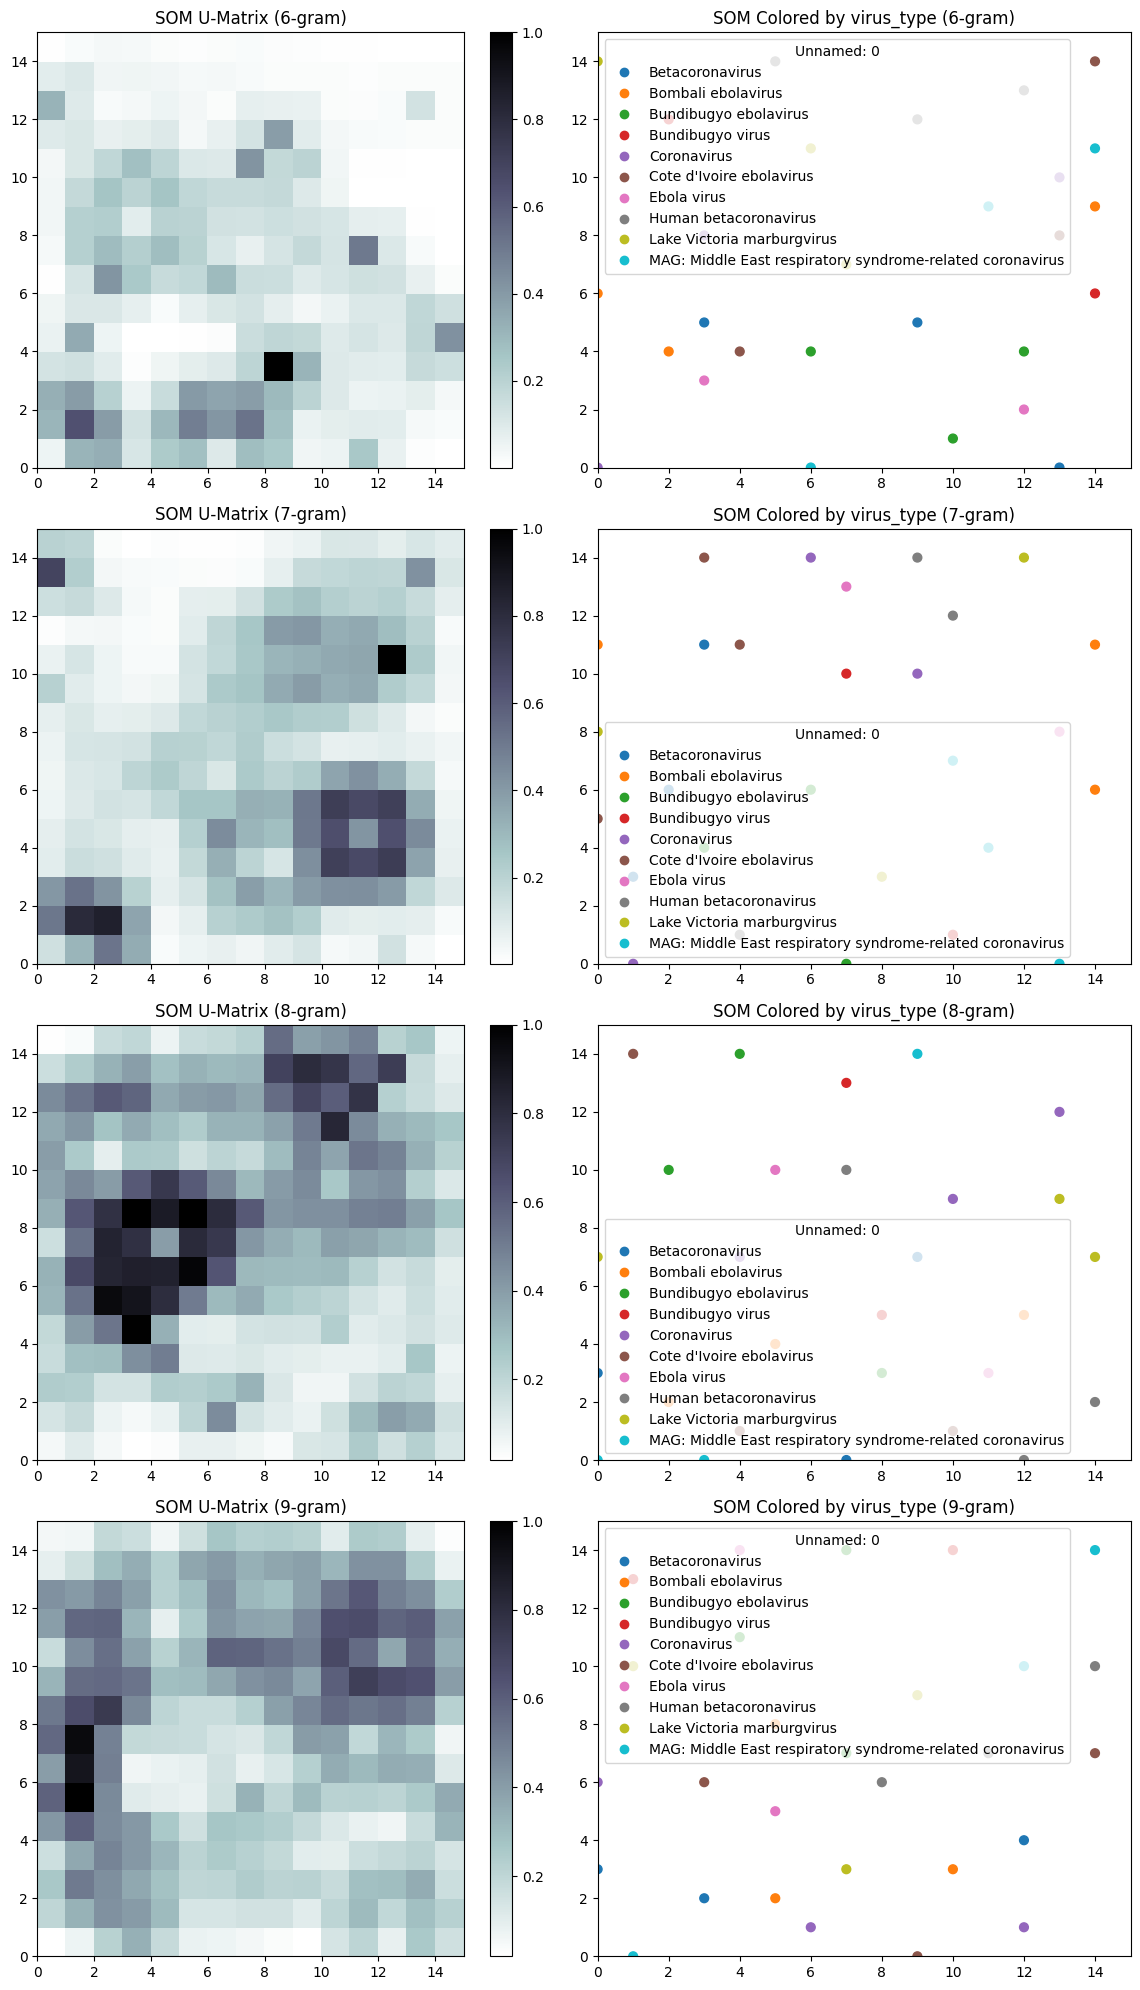

[{'n_gram': '6-gram', 'n_clusters': 28},
 {'n_gram': '7-gram', 'n_clusters': 28},
 {'n_gram': '8-gram', 'n_clusters': 28},
 {'n_gram': '9-gram', 'n_clusters': 28}]

In [4]:
som(datasets, som_x=15, som_y=15, iterations=1000)